In [3]:
import sys

from models.model import BaseNet

sys.path.insert(0, '.')

import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.nn.parallel import gather
import torch.optim.lr_scheduler
from torchvision import transforms
import utils.dataset as myDataLoader
import utils.transforms as myTransforms
from utils.metric_tool import ConfuseMatrixMeter
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os, time
import numpy as np

In [4]:
model = BaseNet(3, 1).cuda()

loading imagenet pretrained mobilenetv2
loaded imagenet pretrained mobilenetv2


In [5]:
#model = torch.nn.DataParallel(model).cuda()

In [6]:
class Normalize(object):
    """
    Given mean: (B, G, R) and std: (B, G, R),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = (channel - mean) / std
    """

    def __init__(self, mean, std):
        '''
        :param mean: global mean computed from dataset
        :param std: global std computed from dataset
        '''
        self.mean = mean
        self.std = std
        self.depth_mean = [0.5]
        self.depth_std = [0.5]

    def __call__(self, image):
        image = image.astype(np.float32)
        image = image / 255
        #label = np.ceil(label / 255)
        for i in range(6):
            image[:, :, i] -= self.mean[i]
        for i in range(6):
            image[:, :, i] /= self.std[i]

        return [image]


class GaussianNoise(object):
    def __init__(self, std=0.05):
        '''
        :param mean: global mean computed from dataset
        :param std: global std computed from dataset
        '''
        self.std = std

    def __call__(self, image):
        noise = np.random.normal(loc=0, scale=self.std, size=image.shape)
        image = image + noise.astype(np.float32)
        return [image]


class ToTensor(object):
    '''
    This class converts the data to tensor so that it can be processed by PyTorch
    '''

    def __init__(self, scale=1):
        '''
        :param scale: set this parameter according to the output scale
        '''
        self.scale = scale

    def __call__(self, image):
        if self.scale != 1:
            h, w = label.shape[:2]
            image = cv2.resize(image, (int(w), int(h)))
            #label = cv2.resize(label, (int(w / self.scale), int(h / self.scale)), \
            #                   interpolation=cv2.INTER_NEAREST)
        image = image[:, :, ::-1].copy()  # .copy() is to solve "torch does not support negative index"
        image = image.transpose((2, 0, 1))
        image_tensor = torch.from_numpy(image)
        # TODO: here, we add unsqueeze to satisfy the condition that
        # adjust_size in DataSet.py should input 4D tensor
        #label_tensor = torch.LongTensor(np.array(label, dtype=np.int)).unsqueeze(dim=0)

        return [image_tensor]


class Compose(object):
    """
    Composes several transforms together.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, *args):
        for t in self.transforms:
            args = t(*args)
        return args

class Scale(object):
    """
    Resize the given image to a fixed scale
    """

    def __init__(self, wi, he):
        '''
        :param wi: width after resizing
        :param he: height after reszing
        '''
        self.w = wi
        self.h = he

    # modified from torchvision to add support for max size

    def __call__(self, img):
        '''
        :param img: RGB image
        :param label: semantic label image
        :return: resized images
        '''
        # bilinear interpolation for RGB image
        img = cv2.resize(img, (self.w, self.h))
        # nearest neighbour interpolation for label image
        #label = cv2.resize(label, (self.w, self.h), interpolation=cv2.INTER_NEAREST)
        return [img]

In [7]:
mean = [0.406, 0.456, 0.485, 0.406, 0.456, 0.485]
std = [0.225, 0.224, 0.229, 0.225, 0.224, 0.229]

# compose the data with transforms
transform = myTransforms.Compose([
    Normalize(mean=mean, std=std),
    Scale(256, 256),
    ToTensor()
])

In [8]:
def preprocess(pre_img, post_img):
    pre_image_name = pre_img
    post_image_name = post_img
    pre_image = cv2.imread(pre_image_name)
    post_image = cv2.imread(post_image_name)
    img = np.concatenate((pre_image, post_image), axis=2)
    # if self.transform:
    #     [pre_image, label, post_image] = self.transform(pre_image, label, post_image)
    #
    # return pre_image, label, post_image
    if transform:
        img = transform(img)

    return img

In [11]:
# load the model
model_file_name = 'checkpoints/best_model.pth'
state_dict = torch.load(model_file_name)
model.load_state_dict(state_dict)
model.eval()

BaseNet(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [13]:
im1= "delA_256_512.png"
im2= "delB_256_512.png"
img = preprocess(im1,im2)[0].unsqueeze(0)

In [14]:
pre_img = img[:, 0:3].cuda()
post_img = img[:, 3:6].cuda()
#pre_img_var = torch.autograd.Variable(pre_img).float()
#post_img_var = torch.autograd.Variable(post_img).float()
pre_img_var = pre_img.float()
post_img_var = post_img.float()
# run the mdoel
output, output2, output3, output4 = model(pre_img_var, post_img_var)

pred = torch.where(output2 > 0.01, torch.ones_like(output), torch.zeros_like(output)).long()

(-0.5, 255.5, 255.5, -0.5)

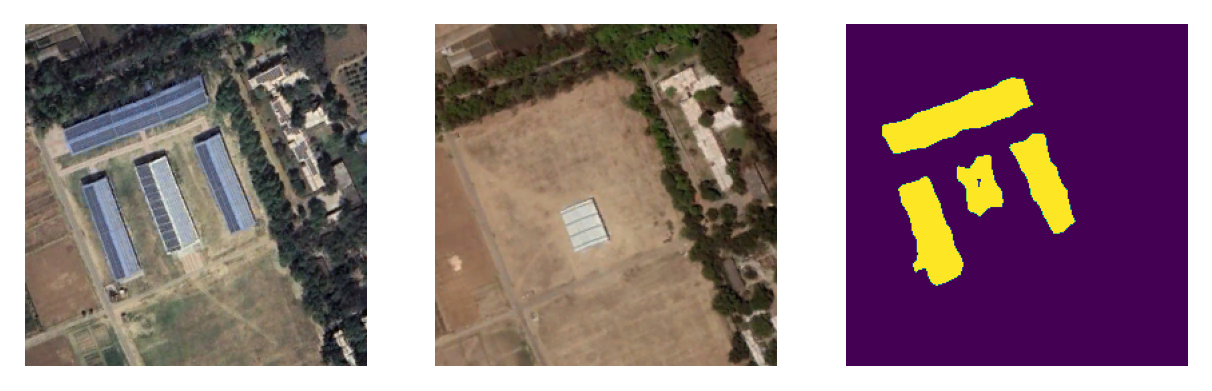

In [17]:
plt.figure(dpi=250)
plt.subplot(131)
plt.imshow(Image.open(im1))
#plt.imshow(imA)
plt.axis("off")
plt.subplot(132)
plt.imshow(Image.open(im2))
#plt.imshow(imB)
plt.axis("off")
plt.subplot(133)
#plt.imshow(Image.open(im2))
plt.imshow(pred.cpu().numpy()[0][0])
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

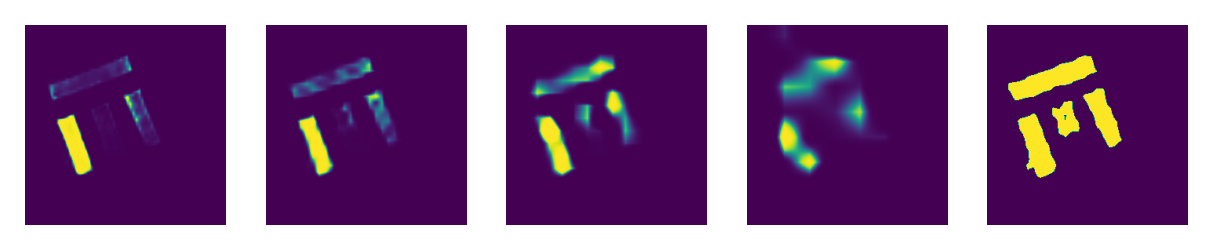

In [18]:
plt.figure(dpi=250)
plt.subplot(151)
plt.imshow(output.cpu().detach().numpy()[0][0])
plt.axis("off")
plt.subplot(152)
plt.imshow(output2.cpu().detach().numpy()[0][0])
plt.axis("off")
plt.subplot(153)
plt.imshow(output3.cpu().detach().numpy()[0][0])
plt.axis("off")
plt.subplot(154)
plt.imshow(output4.cpu().detach().numpy()[0][0])
plt.axis("off")
plt.subplot(155)
#plt.imshow(Image.open(im2))
plt.imshow(pred.cpu().numpy()[0][0])
plt.axis("off")